# Desafio
Dataset com 7121 formulas de medicamentos manipulados.  
O objetivo do teste é prever o valor da coluna "correto" com menor erro possível a partir das outras informações do dataset.  
dos 7121 pontos de dados, pode-se usar no máximo os primeiros 5121 dados do dataset para prever os últimos 2000  
---

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import sklearn

## Load Data

In [89]:
# Carrega o dataset
df = pd.read_csv('https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv')

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB


## Transformação e limpza dos dados

In [91]:
df['criado'] = pd.to_datetime(df.criado)

In [92]:
df['cap'] = [int(x[0]) for x in df.descricao.str.split(' ', 1)]

In [93]:
df['ins'] = [x[1] for x in df.descricao.str.split('|')]

In [94]:
df_ins = df['ins'].apply(lambda x: x.split(';')).apply(pd.Series)

In [95]:
df_ins = df_ins.rename(columns = lambda x: 'ins_' + str(x))

In [96]:
df

,descricao,criado,qtdInsumos,calculado,correto,cap,ins
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG
...,...,...,...,...,...,...,...
7116,45 CAP | SERTRALINA CLORIDRATO 40MG; SLENDEST...,2020-07-09 17:33:11,12,188.5325,181.8,45,SERTRALINA CLORIDRATO 40MG; SLENDESTA 75MG;...
7117,120 CAP | GREENSELECT 120MG,2020-07-09 17:24:09,1,377.6529,346.6,120,GREENSELECT 120MG
7118,60 CAP | MAGNESIO QUELADO 30% 220MG; SELENIO ...,2020-07-09 17:23:10,11,166.2868,157.2,60,MAGNESIO QUELADO 30% 220MG; SELENIO QUELADO ...
7119,30 CAP | VALERIANA 50MG; PASSIFLORA 500MG; C...,2020-07-09 17:22:09,3,60.1646,68.1,30,VALERIANA 50MG; PASSIFLORA 500MG; CAMOMILA ...


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   descricao   7121 non-null   object        
 1   criado      7121 non-null   datetime64[ns]
 2   qtdInsumos  7121 non-null   int64         
 3   calculado   7121 non-null   float64       
 4   correto     7121 non-null   float64       
 5   cap         7121 non-null   int64         
 6   ins         7121 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 389.6+ KB


## Análise Exploratória 1
### Existe correlação entre a data e o preço?

In [98]:
df1 = df.copy()

In [99]:
df1['mes'] = df1.criado.dt.month
df1['dia'] = df1.criado.dt.day
df1['hora'] = df1.criado.dt.hour

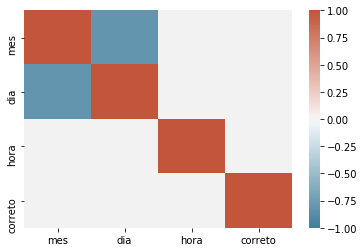

In [100]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df1[['mes', 'dia', 'hora', 'correto']].corr(), vmax=1, vmin=-1, cmap=cmap);

**Não há correlação significativa para considerar a coluna com a timestamp de criação da fórmula**

In [101]:
df.drop('criado', axis=1, inplace=True)

## Transformação e limpza dos dados (parte 2)
Extração dos insumos e respectivas quantidades

In [73]:
df

,descricao,qtdInsumos,calculado,correto,cap,ins
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,60 CAP | FINASTERIDA 1:10 1MG,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,60 CAP | ANASTROZOL 1:10 0.300MG,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG
...,...,...,...,...,...,...
7116,45 CAP | SERTRALINA CLORIDRATO 40MG; SLENDEST...,12,188.5325,181.8,45,SERTRALINA CLORIDRATO 40MG; SLENDESTA 75MG;...
7117,120 CAP | GREENSELECT 120MG,1,377.6529,346.6,120,GREENSELECT 120MG
7118,60 CAP | MAGNESIO QUELADO 30% 220MG; SELENIO ...,11,166.2868,157.2,60,MAGNESIO QUELADO 30% 220MG; SELENIO QUELADO ...
7119,30 CAP | VALERIANA 50MG; PASSIFLORA 500MG; C...,3,60.1646,68.1,30,VALERIANA 50MG; PASSIFLORA 500MG; CAMOMILA ...


In [74]:
print('Total de insumos: ',df.qtdInsumos.sum())

Total de insumos:  23370


In [115]:
"""  
Proporcao em % ou N:N
- regex_prop = r'\d*%|\d:\d*'

Quantidades
- regex_measure = r'(\d*\.\d\w*$)|(\d\w*$)'
- regex_measure = r'  [-+]?([0-9]*\.[0-9]+|[0-9]+)\w*'

- regex_ins = r'([^\d]+)\s'
""";

In [117]:
quantities = []

for itens in df.ins.str.split(';'):
    for item in itens:
        match = re.search(r'(\d*\.\d\w*$)|(\d\w*$)|(\d\w*%$)', item)
#         prop = re.search(r'(\d.\d*%)|(\d*%)|(\d:\d*)', item)
        if match != None:
            quantities.append(match.group())
        else:
            print(item)

In [154]:
quantities[:10]

['150MG',
 '1MG',
 '250MG',
 '150MG',
 '50MG',
 '0.300MG',
 '0.250MG',
 '10MG',
 '12MCG',
 '60MCG']

Extração todas as quantidades com unidades de medida

In [153]:
#Teste
len(quantities) == df.qtdInsumos.sum()

True

In [119]:
units = []
for unit in quantities:
    match = re.search(r'\D*$', unit)
    units.append(match.group())

In [124]:
set(units)

{'%', 'CAP', 'G', 'MCG', 'MG', 'UI', 'UI%', 'UN', 'UTR'}

Estão presentes diferentes unidades de medidas farmacêuticas

In [152]:
#Teste
len(units) == df.qtdInsumos.sum()

True

In [142]:
supplies =[]
for itens in df.ins.str.split(';'):
    for item in itens:
#         print(item, ' ->  ', end='')
        match = re.findall(r'([a-zA-Z_][-a-zA-Z0-9_]*)\s', item)
#         print(' '.join(match))
        supplies.append(' '.join(match))

In [144]:
len(supplies) == df.qtdInsumos.sum()

True

In [149]:
dict(Counter(supplies))

sort_orders = sorted(dict(Counter(insums)).items(), key=lambda x: x[1], reverse=True);
sort_orders[:10]

[('ZINCO QUELADO', 462),
 ('VITAMINA D3', 369),
 ('VITAMINA K2 MK7', 336),
 ('SELENIO QUELADO', 320),
 ('BIOTINA', 314),
 ('METILFOLATO', 307),
 ('VITAMINA D', 293),
 ('MAGNESIO DIMALATO', 288),
 ('VITAMINA D LIQ CAP ATE MIL', 277),
 ('METILCOBALAMINA', 276)]

Extração dos insumos

In [160]:
df[df.qtdInsumos == df.qtdInsumos.max()].ins[1205]

' VITAMINA B6  50MG; METILCOBALAMINA 1:100  400MCG; VITAMINA A  500UI; VITAMINA C  500MG; VITAMINA D  3000UI; VITAMINA E  100UI; VITAMINA K2 MK7 62.500MCG; TIAMINA  25MG; RIBOFLAVINA  15MG; NIACINAMIDA  25MG; METILFOLATO 1:10  400MCG; BIOTINA  200MCG; ACIDO PANTOTENICO  150MG; MAGNESIO DIMALATO  300MG; ZINCO QUELADO  3MG; SELENIO QUELADO  100MCG; COBRE QUELADO 0.300MG; MANGANES QUELADO  2MG; CROMO QUELADO  200MCG; MOLIBDENIO QUELADO  25MCG; BITARTARATO COLINA  50MG; INOSITOL  50MG; TOCOTRIENOIS  100MG; RUTINA  25MG; BORO QUELADO 1.500MG; VANADIO QUELADO  100MCG'